# Bayesian FoldX Re-weighing

In order to make a rational re-weighing of FoldX energy terms upon mutation I took a Bayesian machine learning approach which is more rational than a Random Forest One, that in any case when I discarded half of the cases to predict the others outperformed the original foldX output energy but not as good as before (tautologically) and can be beaten by this kind of analysis I think.

In [2]:
%matplotlib inline

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pymc3 as pm
from scipy.optimize import fmin
from IPython.core.pylabtools import figsize

## Which data we have?

I'm showing here the columns that we have for the dataset of Varibench mutations. For this analysis I'm not considering yet the identity of the residues, we have columns with a 0 and 1 for the originally and mutated aminoacids, to make this perform well over the probabilities sample space better than a binary field we should make something quantitative, I was considering take into account the BLOSUM cost of the mutation. All the analysis below doesn't take into account the AA's identity.

In [5]:
WORKING_PATH = "/home/lradusky/Dropbox/workspacesbg/sbg/sbg/scripts/Varibench/varibench_terms.df"
DF = pd.read_csv(WORKING_PATH, index_col=["PDB","Variation"])
DF = DF[~DF.backbone_clash.isna()]
DF = pd.concat([DF, pd.get_dummies(DF['AA_ori'], prefix="AA_ori")], axis=1)
DF = pd.concat([DF, pd.get_dummies(DF['AA_mut'], prefix="AA_mut")], axis=1)
DF.columns

Index(['ddG', 'pH', 'Chain', 'Temp', 'ddG_WT', 'ddG_REP', 'ddG_RD',
       'ddG_BIOASS', 'BioAssembly', 'Resolution', 'BFactor', 'ddG_Best',
       'Backbone_Hbond', 'Sidechain_Hbond', 'Van_der_Waals', 'Electrostatics',
       'Solvation_Polar', 'Solvation_Hydrophobic', 'Van_der_Waals_clashes',
       'entropy_sidechain', 'entropy_mainchain', 'sloop_entropy',
       'mloop_entropy', 'cis_bond', 'torsional_clash', 'backbone_clash',
       'helix_dipole', 'water_bridge', 'disulfide', 'electrostatic_kon',
       'partial_covalent_bonds', 'energy_Ionisation', 'Entropy_Complex',
       'AA_ori', 'AA_mut', 'sasa', 'sasa_nowat', 'sasa_nohet', 'sasa_noppi',
       'sasa_total', 'AA_ori_A', 'AA_ori_C', 'AA_ori_D', 'AA_ori_E',
       'AA_ori_F', 'AA_ori_G', 'AA_ori_H', 'AA_ori_I', 'AA_ori_K', 'AA_ori_L',
       'AA_ori_M', 'AA_ori_N', 'AA_ori_P', 'AA_ori_Q', 'AA_ori_R', 'AA_ori_S',
       'AA_ori_T', 'AA_ori_V', 'AA_ori_W', 'AA_ori_Y', 'AA_mut_A', 'AA_mut_C',
       'AA_mut_D', 'AA_mut_E', 'AA_m

This is just to force all the columns of the analysis be floating point numbers:

In [6]:
DF["Resolution"            ] = DF["Resolution"            ].astype(float)
DF["BFactor"               ] = DF["BFactor"               ].astype(float)
DF["Backbone_Hbond"        ] = DF["Backbone_Hbond"        ].astype(float)
DF["Sidechain_Hbond"       ] = DF["Sidechain_Hbond"       ].astype(float)
DF["Van_der_Waals"         ] = DF["Van_der_Waals"         ].astype(float)
DF["Electrostatics"        ] = DF["Electrostatics"        ].astype(float)
DF["Solvation_Polar"       ] = DF["Solvation_Polar"       ].astype(float)
DF["Solvation_Hydrophobic" ] = DF["Solvation_Hydrophobic" ].astype(float)
DF["Van_der_Waals_clashes" ] = DF["Van_der_Waals_clashes" ].astype(float)
DF["entropy_sidechain"     ] = DF["entropy_sidechain"     ].astype(float)
DF["entropy_mainchain"     ] = DF["entropy_mainchain"     ].astype(float)
DF["sloop_entropy"         ] = DF["sloop_entropy"         ].astype(float)
DF["mloop_entropy"         ] = DF["mloop_entropy"         ].astype(float)
DF["cis_bond"              ] = DF["cis_bond"              ].astype(float)
DF["torsional_clash"       ] = DF["torsional_clash"       ].astype(float)
DF["backbone_clash"        ] = DF["backbone_clash"        ].astype(float)
DF["helix_dipole"          ] = DF["helix_dipole"          ].astype(float)
DF["water_bridge"          ] = DF["water_bridge"          ].astype(float)
DF["disulfide"             ] = DF["disulfide"             ].astype(float)
DF["electrostatic_kon"     ] = DF["electrostatic_kon"     ].astype(float)
DF["partial_covalent_bonds"] = DF["partial_covalent_bonds"].astype(float)
DF["energy_Ionisation"     ] = DF["energy_Ionisation"     ].astype(float)
DF["Entropy_Complex"       ] = DF["Entropy_Complex"       ].astype(float)
DF["sasa"                  ] = DF["sasa"                  ].astype(float)
DF["sasa_nowat"            ] = DF["sasa_nowat"            ].astype(float)
DF["sasa_nohet"            ] = DF["sasa_nohet"            ].astype(float)
DF["sasa_noppi"            ] = DF["sasa_noppi"            ].astype(float)

## Building the Bayesian model

Here we're gonna make a bayesian inference of the multiplicative coefficients that we need for each feature in order to get the better experimental $\Delta \Delta G$ prediction. Each coefficient have a very wide "initial guess", a normal centered at cero with a standard deviation of 100. We train the model to approximate what we call **mean**, each observation of the features being multiplied by the coefficients that we want to infer, to the **observations** of experimental $\Delta \Delta G$. I just made a small run of 50K iterations.

In [71]:
with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    
    coef_Resolution             = pm.Normal("coef_Resolution"            , mu=0, sd=100)
    coef_BFactor                = pm.Normal("coef_BFactor"               , mu=0, sd=100)
    coef_Backbone_Hbond         = pm.Normal("coef_Backbone_Hbond"        , mu=0, sd=100)
    coef_Sidechain_Hbond        = pm.Normal("coef_Sidechain_Hbond"       , mu=0, sd=100)
    coef_Van_der_Waals          = pm.Normal("coef_Van_der_Waals"         , mu=0, sd=100)
    coef_Electrostatics         = pm.Normal("coef_Electrostatics"        , mu=0, sd=100)
    coef_Solvation_Polar        = pm.Normal("coef_Solvation_Polar"       , mu=0, sd=100)
    coef_Solvation_Hydrophobic  = pm.Normal("coef_Solvation_Hydrophobic" , mu=0, sd=100)
    coef_Van_der_Waals_clashes  = pm.Normal("coef_Van_der_Waals_clashes" , mu=0, sd=100)
    coef_entropy_sidechain      = pm.Normal("coef_entropy_sidechain"     , mu=0, sd=100)
    coef_entropy_mainchain      = pm.Normal("coef_entropy_mainchain"     , mu=0, sd=100)
    coef_sloop_entropy          = pm.Normal("coef_sloop_entropy"         , mu=0, sd=100)
    coef_mloop_entropy          = pm.Normal("coef_mloop_entropy"         , mu=0, sd=100)
    coef_cis_bond               = pm.Normal("coef_cis_bond"              , mu=0, sd=100)
    coef_torsional_clash        = pm.Normal("coef_torsional_clash"       , mu=0, sd=100)
    coef_backbone_clash         = pm.Normal("coef_backbone_clash"        , mu=0, sd=100)
    coef_helix_dipole           = pm.Normal("coef_helix_dipole"          , mu=0, sd=100)
    coef_water_bridge           = pm.Normal("coef_water_bridge"          , mu=0, sd=100)
    coef_disulfide              = pm.Normal("coef_disulfide"             , mu=0, sd=100)
    coef_electrostatic_kon      = pm.Normal("coef_electrostatic_kon"     , mu=0, sd=100)
    coef_partial_covalent_bonds = pm.Normal("coef_partial_covalent_bonds", mu=0, sd=100)
    coef_energy_Ionisation      = pm.Normal("coef_energy_Ionisation"     , mu=0, sd=100)
    coef_Entropy_Complex        = pm.Normal("coef_Entropy_Complex"       , mu=0, sd=100)
    coef_sasa                   = pm.Normal("coef_sasa"                  , mu=0, sd=100)
    coef_sasa_nowat             = pm.Normal("coef_sasa_nowat"            , mu=0, sd=100)
    coef_sasa_nohet             = pm.Normal("coef_sasa_nohet"            , mu=0, sd=100)
    coef_sasa_noppi             = pm.Normal("coef_sasa_noppi"            , mu=0, sd=100)

        
    # Deterministic variable that depends of random variables (coefficients)
    mean = pm.Deterministic("mean", DF["Resolution"            ].values * coef_Resolution             +
                                    DF["BFactor"               ].values * coef_BFactor                +
                                    DF["Backbone_Hbond"        ].values * coef_Backbone_Hbond         +
                                    DF["Sidechain_Hbond"       ].values * coef_Sidechain_Hbond        +
                                    DF["Van_der_Waals"         ].values * coef_Van_der_Waals          +
                                    DF["Electrostatics"        ].values * coef_Electrostatics         +
                                    DF["Solvation_Polar"       ].values * coef_Solvation_Polar        +
                                    DF["Solvation_Hydrophobic" ].values * coef_Solvation_Hydrophobic  +
                                    DF["Van_der_Waals_clashes" ].values * coef_Van_der_Waals_clashes  +
                                    DF["entropy_sidechain"     ].values * coef_entropy_sidechain      +
                                    DF["entropy_mainchain"     ].values * coef_entropy_mainchain      +
                                    DF["sloop_entropy"         ].values * coef_sloop_entropy          +
                                    DF["mloop_entropy"         ].values * coef_mloop_entropy          +
                                    DF["cis_bond"              ].values * coef_cis_bond               +
                                    DF["torsional_clash"       ].values * coef_torsional_clash        +
                                    DF["backbone_clash"        ].values * coef_backbone_clash         +
                                    DF["helix_dipole"          ].values * coef_helix_dipole           +
                                    DF["water_bridge"          ].values * coef_water_bridge           +
                                    DF["disulfide"             ].values * coef_disulfide              +
                                    DF["electrostatic_kon"     ].values * coef_electrostatic_kon      +
                                    DF["partial_covalent_bonds"].values * coef_partial_covalent_bonds +
                                    DF["energy_Ionisation"     ].values * coef_energy_Ionisation      +
                                    DF["Entropy_Complex"       ].values * coef_Entropy_Complex        +
                                    DF["sasa"                  ].values * coef_sasa                   +
                                    DF["sasa_nowat"            ].values * coef_sasa_nowat             +
                                    DF["sasa_nohet"            ].values * coef_sasa_nohet             +
                                    DF["sasa_noppi"            ].values * coef_sasa_noppi             )
    
    # We want to adjust mean and std and we have the observed data, we link them like this.
    obs = pm.Normal("obs", mu=mean, sd=std, observed= DF["ddG"].values )
    
    trace = pm.sample(50000, step=pm.Metropolis())

100%|██████████| 50500/50500 [07:36<00:00, 110.72it/s]


## Checking convergence of the inferred coefficients

In bayesian inference, we don't get a number for each coefficient, but a **probability distribution**. Then, we should check that the guessess that we made **converged** to a gaussian or combination of gaussian distributions (each peak for different conditional states). We discard the first 20000 iterations, since it take several iterations going from the really wide initial guess to the converged inferred values of the coeffitients. We plot the distributions for each coefficient.

In [72]:
burned_trace = trace[20000:] 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8272c8c908>,
      dtype=object)

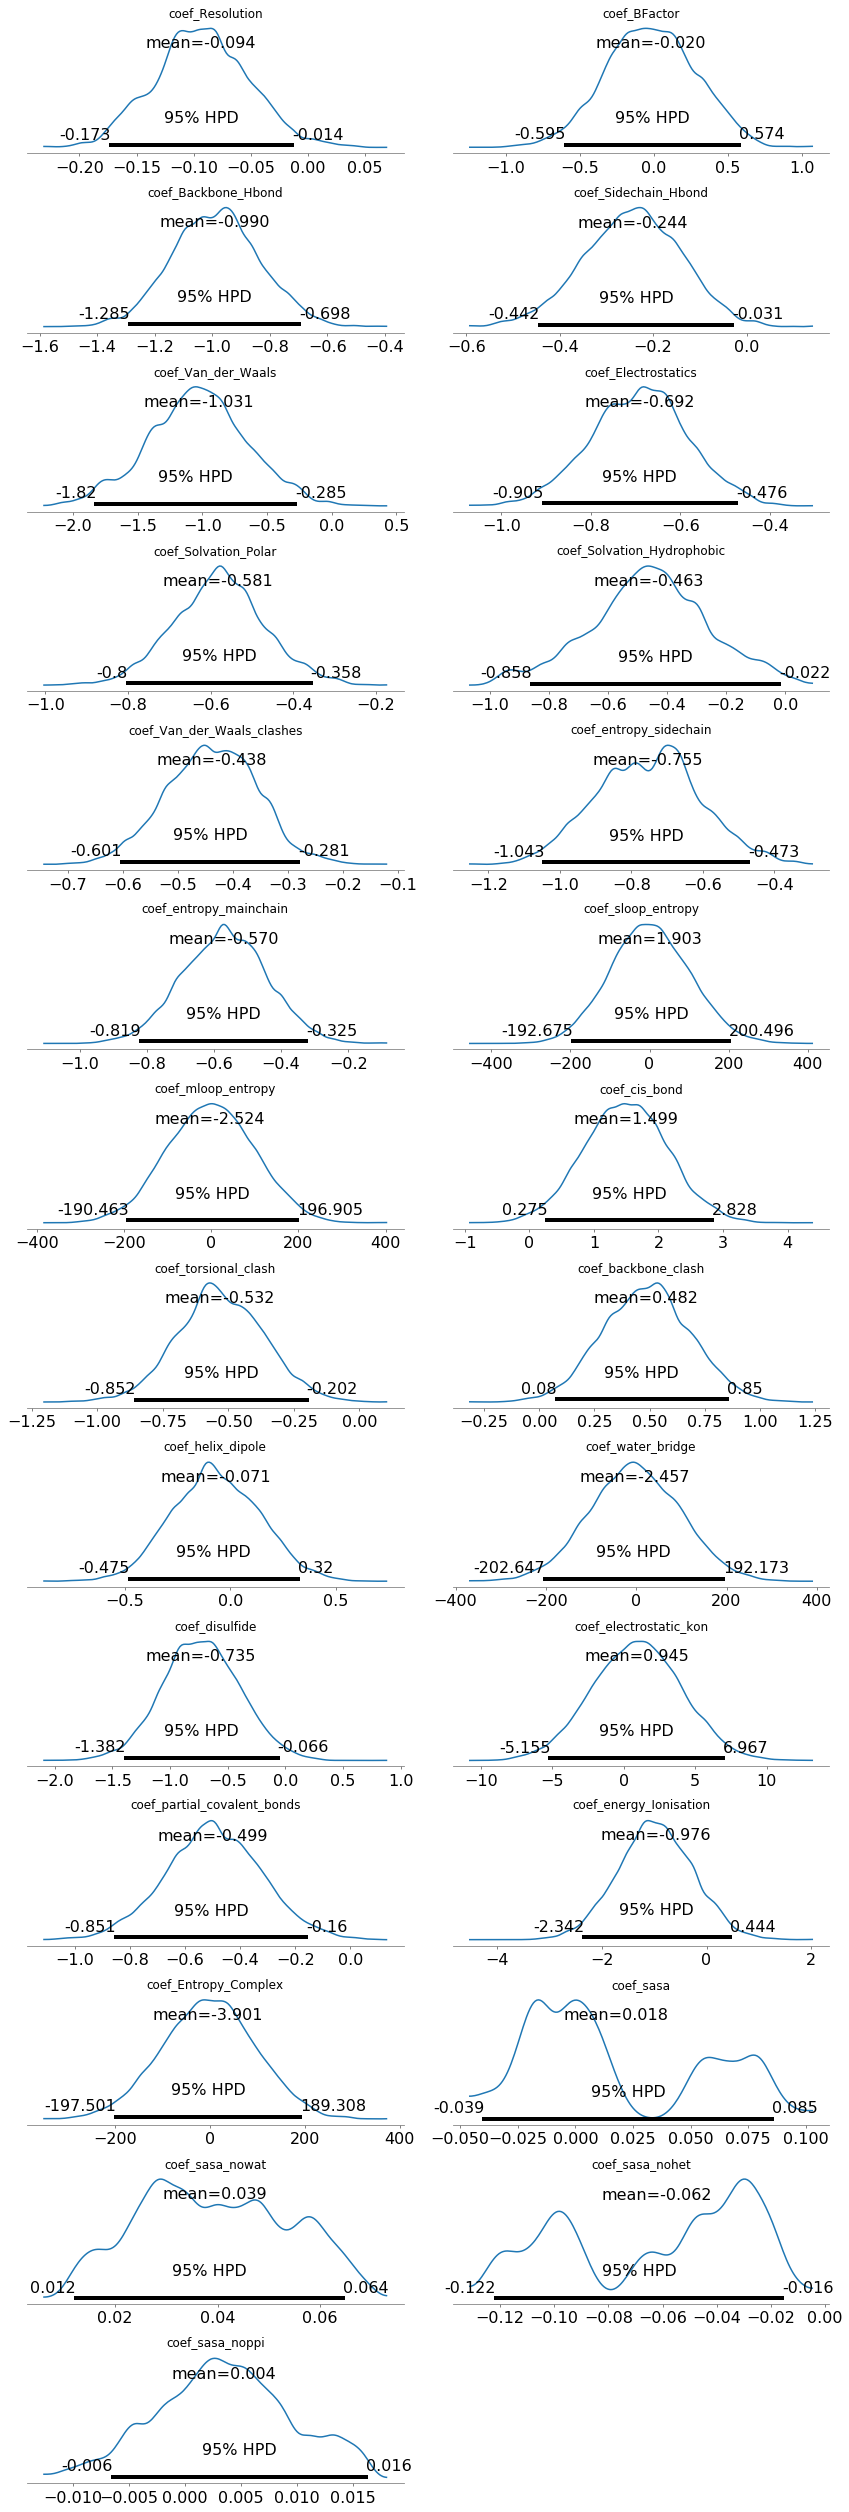

In [102]:
pm.plot_posterior(trace=burned_trace, varnames=["coef_Resolution","coef_BFactor","coef_Backbone_Hbond","coef_Sidechain_Hbond",
"coef_Van_der_Waals","coef_Electrostatics","coef_Solvation_Polar",
"coef_Solvation_Hydrophobic","coef_Van_der_Waals_clashes","coef_entropy_sidechain",
"coef_entropy_mainchain","coef_sloop_entropy","coef_mloop_entropy","coef_cis_bond",
"coef_torsional_clash","coef_backbone_clash","coef_helix_dipole","coef_water_bridge",
"coef_disulfide","coef_electrostatic_kon","coef_partial_covalent_bonds","coef_energy_Ionisation",
"coef_Entropy_Complex","coef_sasa","coef_sasa_nowat","coef_sasa_nohet","coef_sasa_noppi"], kde_plot=True)

The number of iterations where enough to converge, we should try with more in the real paper. The unconverged parameters usually don't have tails in the gausians, meaning that the probability density function move a lot in wider rangers while the Metropolis work is made. 
Some of the coefficients are clearly conditional: they have different peaks of high probability which should depend of other coefficients.

## Evaluating our mutations

Given the probabilities for each coefficients you have to have in mind that each curve where constructed by the 30000 guesses that we made in the metropolis walk. So we will evaluate each row of the official Varibench dataset on each of this 30K values trying to get the best guess (the best combination of coefficients). 

In [103]:
def possible_outcomes(Resolution,BFactor,Backbone_Hbond,Sidechain_Hbond,\
                            Van_der_Waals,Electrostatics,Solvation_Polar,\
                            Solvation_Hydrophobic,Van_der_Waals_clashes,entropy_sidechain,\
                            entropy_mainchain,sloop_entropy,mloop_entropy,cis_bond,\
                            torsional_clash,backbone_clash,helix_dipole,water_bridge,\
                            disulfide,electrostatic_kon,partial_covalent_bonds,energy_Ionisation,\
                            Entropy_Complex,sasa,sasa_nowat,sasa_nohet,sasa_noppi):
    return Resolution      * burned_trace.get_values("coef_Resolution")             +\
    BFactor                * burned_trace.get_values("coef_BFactor")                +\
    Backbone_Hbond         * burned_trace.get_values("coef_Backbone_Hbond")         +\
    Sidechain_Hbond        * burned_trace.get_values("coef_Sidechain_Hbond")        +\
    Van_der_Waals          * burned_trace.get_values("coef_Van_der_Waals")          +\
    Electrostatics         * burned_trace.get_values("coef_Electrostatics")         +\
    Solvation_Polar        * burned_trace.get_values("coef_Solvation_Polar")        +\
    Solvation_Hydrophobic  * burned_trace.get_values("coef_Solvation_Hydrophobic")  +\
    Van_der_Waals_clashes  * burned_trace.get_values("coef_Van_der_Waals_clashes")  +\
    entropy_sidechain      * burned_trace.get_values("coef_entropy_sidechain")      +\
    entropy_mainchain      * burned_trace.get_values("coef_entropy_mainchain")      +\
    sloop_entropy          * burned_trace.get_values("coef_sloop_entropy")          +\
    mloop_entropy          * burned_trace.get_values("coef_mloop_entropy")          +\
    cis_bond               * burned_trace.get_values("coef_cis_bond")               +\
    torsional_clash        * burned_trace.get_values("coef_torsional_clash")        +\
    backbone_clash         * burned_trace.get_values("coef_backbone_clash")         +\
    helix_dipole           * burned_trace.get_values("coef_helix_dipole")           +\
    water_bridge           * burned_trace.get_values("coef_water_bridge")           +\
    disulfide              * burned_trace.get_values("coef_disulfide")              +\
    electrostatic_kon      * burned_trace.get_values("coef_electrostatic_kon")      +\
    partial_covalent_bonds * burned_trace.get_values("coef_partial_covalent_bonds") +\
    energy_Ionisation      * burned_trace.get_values("coef_energy_Ionisation")      +\
    Entropy_Complex        * burned_trace.get_values("coef_Entropy_Complex")        +\
    sasa                   * burned_trace.get_values("coef_sasa")                   +\
    sasa_nowat             * burned_trace.get_values("coef_sasa_nowat")             +\
    sasa_nohet             * burned_trace.get_values("coef_sasa_nohet")             +\
    sasa_noppi             * burned_trace.get_values("coef_sasa_noppi")             

## Taking the best guess

For each mutation in Varibench, we evaluate and we take the better combination of parameters that make closer the linear estimation with the experimental $\Delta \Delta G$. In red crosses you have the best prediction between the repaired, the REDO+repair and the bioassemblies models. In blue points the predictions after re-weightening. 

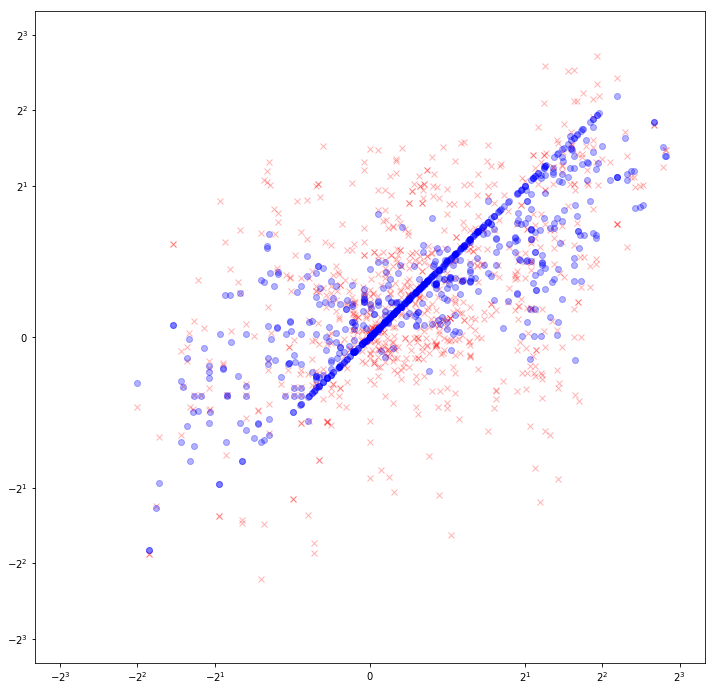

In [100]:
X_PRED = []
for i, row in DF.iterrows():
    X_PRED.append( -1*min(possible_outcomes(row.Resolution,row.BFactor,row.Backbone_Hbond,row.Sidechain_Hbond,row.Van_der_Waals,
                        row.Electrostatics,row.Solvation_Polar,row.Solvation_Hydrophobic,row.Van_der_Waals_clashes,
                        row.entropy_sidechain,row.entropy_mainchain,row.sloop_entropy,row.mloop_entropy,row.cis_bond,
                        row.torsional_clash,row.backbone_clash,row.helix_dipole,row.water_bridge,row.disulfide,
                        row.electrostatic_kon,row.partial_covalent_bonds,row.energy_Ionisation,row.Entropy_Complex,
                        row.sasa,row.sasa_nowat,row.sasa_nohet,row.sasa_noppi), key=lambda x:abs(x-row.ddG)))

figsize(12, 12)
plt.ylim((-10,10))
plt.xlim((-10,10))
plt.xscale('symlog', basex=2)
plt.yscale('symlog', basey=2)
plt.plot(-DF.ddG, DF.ddG_Best, "rx", alpha=0.3)
plt.plot(-DF.ddG, X_PRED, "bo", alpha=0.3)


Having this amazing correlation is a good starting point, this means that the range that we have for each coefficient is very good and is within the proper limits. 

## What else is needed to do:

- Re-run the inference with at least 10 time more iterations.
- See again and carefully all the Varibench datasets since some are contradictory, add double mutants, interaction affecting mutants, etc. They have them but I just took point mutations.
- For those mutations out of the perfect regression: re-run build model with several runs and predicting waters to see if its that we didn't find the good rotamer, or see what happen.
- Incorpore the identity of the residues in a quantitative way as mentioned above because this will help.
- This is the best combination of multiplicative factors, we should then infer the conditions that make this approximation good to implement it in Foldx, when we choose in the future this conditional combinations. The curve accuracy will go down for the predictive power **but not as bad as the Random Forest Regressor** since we are just playing here with small ranges for the factors with are rational and not making maquiavelic decision trees that explode badly in the extrapolations. 
- Consider the use of **loss functions**: the good with bayesian methods also is that you can decide how to penalize the errors. When we decide to take the best decision we don't want to consider all the errors the same. Suppose we are predicting stock marked: if we win 0.1 or 0.3 with a stock we will be more or less happy, while lossing 0.1 and winning 0.1, even if the distance of the error is 0.2 like the previous scenario, we are happy with one and sad with the other. Here with $\Delta \Delta G$s is the same: around the zero we want to be more precise and we can penalize more this errors than those that are saying 6 kcal/mol instead of 4 kcal/mol, this have to be plugged at the moment of making the best guesses for the multiplicative factors by finding the minimun (the derivative being zero) over the 30000 values "deforming" the errors to be bigger close to zero.
- Import the generated model in python to C++ and add it into FoldX or ModelX (where?) or program it there (in Stan language for example).
- Write the paper, validate, make it available, etc.